In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
import calendar
from scipy import stats
import sys
import folium

In [217]:
# load the data
data = pd.read_csv('anzdata.csv')

In [218]:
# create dataframe for analysis
df = data

In [219]:
# inspect the data
df.head()

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,...,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,...,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,...,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,...,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit
3,authorized,1.0,NaN,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,...,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05 -26.68,debit
4,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,...,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44 -28.06,debit


In [220]:
# summarise the data
df.describe()

,card_present_flag,merchant_code,balance,age,amount
count,7717.000000,883.0,12043.000000,12043.000000,12043.000000
mean,0.802644,0.0,14704.195553,30.582330,187.933588
std,0.398029,0.0,31503.722652,10.046343,592.599934
min,0.000000,0.0,0.240000,18.000000,0.100000
25%,1.000000,0.0,3158.585000,22.000000,16.000000
50%,1.000000,0.0,6432.010000,28.000000,29.000000
75%,1.000000,0.0,12465.945000,38.000000,53.655000
max,1.000000,0.0,267128.520000,78.000000,8835.980000


In [221]:
# data above shows that balance, age, amount have 12043 values
# this suggests there are missing or null values in card_present_flag and merchant_code
# find % of data with missing values
miss_perc = (df.isnull().sum() / len(df)*100).round(2)
miss_perc = pd.DataFrame(miss_perc, columns = ['missing%']).reset_index().sort_values(by=['missing%'], ascending = False)
miss_perc.columns = ['feature', 'missing%']
miss_perc

,feature,missing%
8,merchant_code,92.67
2,bpay_biller_code,92.65
14,merchant_suburb,35.92
21,merchant_long_lat,35.92
7,merchant_id,35.92
1,card_present_flag,35.92
15,merchant_state,35.92
0,status,0.00
20,customer_id,0.00
19,country,0.00


<AxesSubplot:xlabel='feature', ylabel='missing%'>

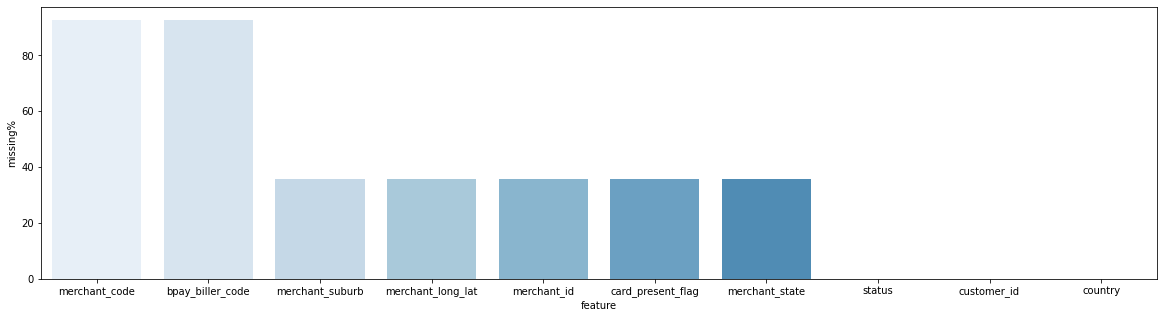

In [222]:
# plot the missing data percent
plt.figure(figsize=(20,5))
sns.barplot(x='feature', y='missing%', data=miss_perc.head(10), palette = 'Blues')

In [223]:
# clean the data
# drop columns with > 40% missing values as these won't be much use to the model
df = df.drop(['merchant_code', 'bpay_biller_code'], axis=1)

In [224]:
df.columns

Index(['status', 'card_present_flag', 'account', 'currency', 'long_lat',
       'txn_description', 'merchant_id', 'first_name', 'balance', 'date',
       'gender', 'age', 'merchant_suburb', 'merchant_state', 'extraction',
       'amount', 'transaction_id', 'country', 'customer_id',
       'merchant_long_lat', 'movement'],
      dtype='object')

In [225]:
# fill missing values (except for those dropped)
# numerical data to be filled with mean, categorical data to be filled with mode
num_cols = ['age','amount', 'balance']
cat_cols = ['status', 'card_present_flag', 'account', 'currency', 'long_lat',
       'txn_description', 'merchant_id', 'first_name', 'date',
       'gender', 'merchant_suburb', 'merchant_state', 'extraction', 'transaction_id', 'country', 'customer_id',
       'merchant_long_lat', 'movement']

In [226]:
#  fill missing numerical values with mean
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

In [227]:
# fill missing categorical values with mode
df[cat_cols] = df[cat_cols].transform(lambda x: x.fillna(x.mode()[0]))

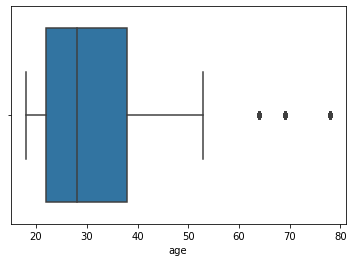

In [228]:
# plot boxplots to find outliers
# plot boxplot on age
ax = sns.boxplot(df['age'])

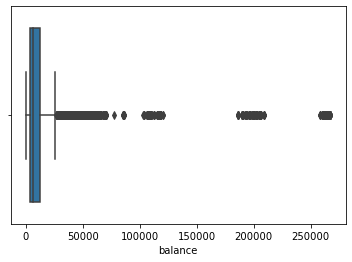

In [229]:
# plot boxplot on balance
ax = sns.boxplot(df['balance'])

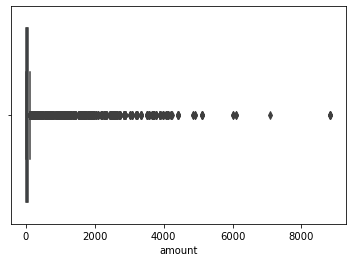

In [230]:
# plot boxplot on amount
ax = sns.boxplot(df['amount'])

In [231]:
# find outliers using z score
z = np.abs(stats.zscore(df[num_cols]))

In [232]:
# set threshold at which outliers should be excluded
threshold = 3

In [233]:
# calculate percentage of datapoint which are outliers
outlier_perc = (100-(df[num_cols][(z<3).all(axis=1)].count()) / len(df[num_cols])*100).reset_index()
outlier_perc.rename(columns={'index':'feature', 0:'outlier%'})

,feature,outlier%
0,age,6.526613
1,amount,6.526613
2,balance,6.526613


In [234]:
# describe data before correcting outliers
df[num_cols].describe()

,age,amount,balance
count,12043.000000,12043.000000,12043.000000
mean,30.582330,187.933588,14704.195553
std,10.046343,592.599934,31503.722652
min,18.000000,0.100000,0.240000
25%,22.000000,16.000000,3158.585000
50%,28.000000,29.000000,6432.010000
75%,38.000000,53.655000,12465.945000
max,78.000000,8835.980000,267128.520000


In [235]:
# replace outliers with median value
median = df[num_cols].median()
df[num_cols] = np.where(z>threshold, median, df[num_cols])

# describe data after correcting outliers
df[num_cols].describe()

,age,amount,balance
count,12043.000000,12043.000000,12043.000000
mean,29.830856,103.662676,10539.170394
std,8.571904,281.779685,13306.808840
min,18.000000,0.100000,0.240000
25%,22.000000,16.000000,3158.585000
50%,28.000000,29.000000,6432.010000
75%,38.000000,48.880000,11525.535000
max,53.000000,1965.000000,108791.320000


In [236]:
# find insights
# 1. average transaction amount
av_t = df['amount'].mean()
av_t

103.66267624346094

In [255]:
# find insights
# 2. transactions made by customers each month, on average
# add month_year field
df['month_year'] = df['date'].str[3:]

# groupby and count transactions made by customers
df_tra = df.groupby('month_year')['transaction_id'].count().reset_index()
df_tra.columns = ['month_year', 'num_transactions']

# calculate mean num transactions made each month
df_tra['num_transactions'].mean()

4014.3333333333335

In [238]:
# segment transaction by date and time
# date columns already exists
# extract time from extraction columns and add as new column
df['time'] = df['extraction'].str[11:19]

In [239]:
# create another column timestamp which has time and date
df['timestamp'] = df['extraction'].str[:10] +' ' + df['time']

In [240]:
# set timestamp to datetime format to enable timeseries analysis
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [241]:
# generate daily data (sum data by hour)
df_dly = df.set_index('timestamp').resample('D').sum().reset_index()

<AxesSubplot:title={'center':'Daily Sum of Transaction Amount - Full Observation Period'}, xlabel='timestamp', ylabel='amount'>

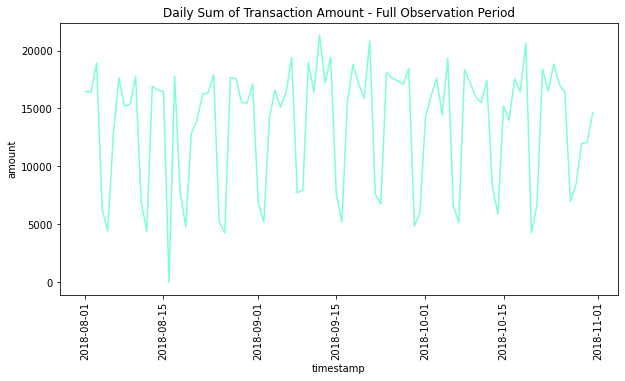

In [262]:
#  plot daily data 
plt.figure(figsize=(10,5))
plt.xticks(rotation = 90)
plt.title('Daily Sum of Transaction Amount - Full Observation Period')
sns.lineplot(x = 'timestamp', y='amount', data=df_dly, color='aquamarine')

In [243]:
# select daily data for 1 month
start_day = '2018-09-01'
end_day = '2018-09-30'
mo_df = df_dly[(df_dly['timestamp'] >= start_day) & (df_dly['timestamp'] <= end_day)]

<AxesSubplot:title={'center':'Daily Sum of Transaction Amount - September'}, xlabel='timestamp', ylabel='amount'>

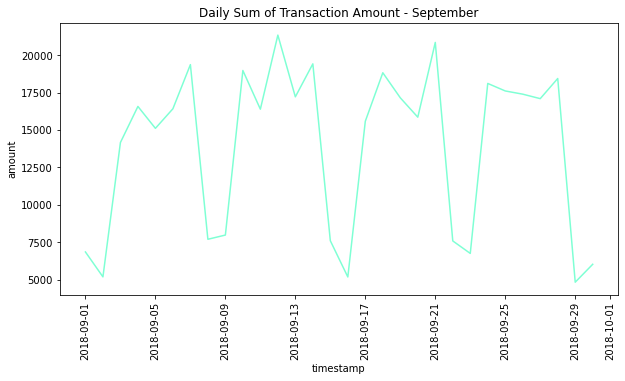

In [261]:
# plot daily data over 1 month
plt.figure(figsize=(10,5))
plt.xticks(rotation = 90)
plt.title('Daily Sum of Transaction Amount - September')
sns.lineplot(x = 'timestamp', y='amount', data=mo_df, color='aquamarine')

In [245]:
# reset timestamp
# create another column timestamp which has time and date
df['timestamp'] = df['extraction'].str[:10] +' ' + df['time']

# set as datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [246]:
# generate hourly data (sum data by hour)
df_hrly = df.set_index('timestamp').resample('H').sum().reset_index()
df_hrly.rename(columns={'timestamp':'datetime'}, inplace=True)
df_hrly.head()

,datetime,card_present_flag,balance,age,amount
0,2018-08-01 01:00:00,4.0,2197.47,156.0,81.01
1,2018-08-01 02:00:00,2.0,2953.79,63.0,224.06
2,2018-08-01 03:00:00,0.0,0.00,0.0,0.00
3,2018-08-01 04:00:00,2.0,1445.91,70.0,34.86
4,2018-08-01 05:00:00,0.0,0.00,0.0,0.00


<AxesSubplot:title={'center':'Hourly Transaction Amount'}, xlabel='datetime', ylabel='amount'>

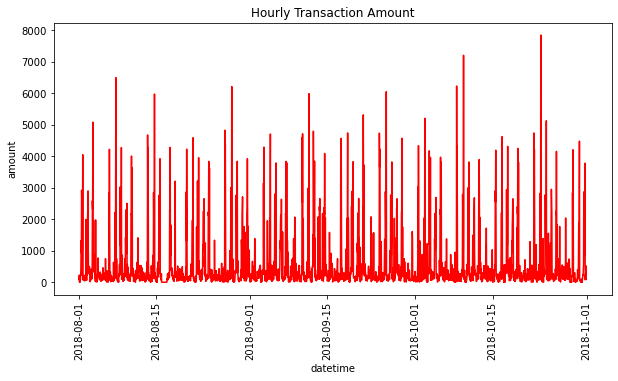

In [259]:
# plt hourly data
plt.figure(figsize=(10,5))
plt.xticks(rotation = 90)
plt.title('Hourly Sum of Transaction Amount - Full Observation Period')
sns.lineplot(x='datetime', y='amount', data=df_hrly, color='Red')

In [248]:
# visualise over 1 day
# select daily data for 1 day
start_time = '2018-09-15 00:00:00'
end_time = '2018-09-16 00:00:00'
d_df = df_hrly[(df_hrly['datetime'] >= start_time) & (df_hrly['datetime'] <= end_time)]

<AxesSubplot:title={'center':'Hourly Sum of Transaction Amount - 15/09/2018'}, xlabel='datetime', ylabel='amount'>

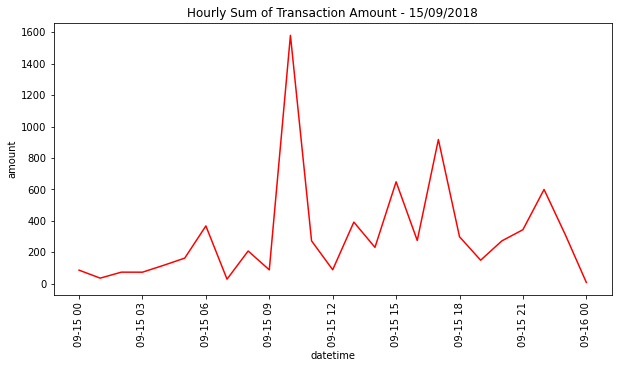

In [267]:
# plot data for 1 day
plt.figure(figsize=(10,5))
plt.xticks(rotation = 90)
plt.title('Hourly Sum of Transaction Amount - 15/09/2018')
sns.lineplot(x='datetime', y='amount', data=d_df, color='Red')

In [250]:
# calculate amount by location to form basis for heatmap
df_h = df.groupby(['long_lat'])['amount'].sum().reset_index()

In [251]:
# what data can be drawn from the location information
# add new columns for long and lat
df_h['long'] = df_h['long_lat'].str[:6]
df_h['lat'] = df_h['long_lat'].str[-6:]

In [252]:
# create geodataframe using geometry from long_lat feature
gdf = geopandas.GeoDataFrame(df_h, geometry=geopandas.points_from_xy(df_h['long'],df_h['lat']))
gdf.head()

,long_lat,amount,long,lat,geometry
0,114.62 -28.80,18810.09,114.62,-28.80,POINT (114.62000 -28.80000)
1,115.72 -32.28,23233.50,115.72,-32.28,POINT (115.72000 -32.28000)
2,115.74 -31.72,23070.56,115.74,-31.72,POINT (115.74000 -31.72000)
3,115.78 -31.90,22141.51,115.78,-31.90,POINT (115.78000 -31.90000)
4,115.79 -31.79,21856.81,115.79,-31.79,POINT (115.79000 -31.79000)


In [268]:
# create heatmap using folium
# create map
m_1 = folium.Map(location=[-25,135], titles='cartodbpositron', zoom_start=4)
m_1

# create heatmap, use max value from amount to amount normalise column as heat map weighting scales against 1 
# e.g. 0.5 = low density, 1 = high density
folium.plugins.HeatMap(data=gdf[['lat','long','amount']], max_val =gdf['amount'].max(), radius=25).add_to(m_1)
m_1